## Simple Refit Result Analysis
---

The simple refit result is horrible...which does not make sense. Let's produce some information on it.

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns

import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#### Static Snapshot Indeterminate distributions

In [2]:
%%time
df = pd.read_feather("../../data/combined_all_features/combined_1618211254.feather")

CPU times: user 8.4 s, sys: 12.1 s, total: 20.5 s
Wall time: 6min 58s


In [3]:
df_ = df[df.is_static & (df.sample_date==pd.to_datetime("2021-01-01"))]

In [4]:
def build_indeterminate(df):
    return ((pd.to_datetime(df["dtc"]) <= df["sample_date"])
            | (df["last_unrestricted_date"] <= df["sample_date"])
            | (df["chg_wrt_off_date"] <= df["sample_date"])
            | (df["target"] & (df["latest_acc_bal"] > 0))
            | (
                ~df["target"] & (~df["chg_wrt_off_date"].isna())
                | (df["latest_acc_bal"] < 0)
                | (
                    df["closed_reason"].isin(
                        [
                            "Closed by SoFi - Risk Request",
                            "Closed by SoFi - Charge-Off / Write-Off",
                        ]
                    )
                )
                | (df["restricted_reason"].str.startswith("No"))
            ))
   
df_["indeterminate"] = build_indeterminate(df_)
df_[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.900826
        True             0.091538
True    False            0.000825
        True             0.006811
dtype: float64

In [5]:
# how many of the bads are indeterminate?
df_[df.target].indeterminate.value_counts(), df_[df.target].indeterminate.value_counts(normalize=True)

True     4447
False     539
Name: indeterminate, dtype: int64

In [60]:
# how about the ind/bad ratio for the old data
df_prev = df[df.is_static & (df.sample_date==pd.to_datetime("2020-01-01"))]
df_prev["indeterminate"] = build_indeterminate(df_prev)
df_prev.shape

(166419, 91)

In [62]:
df_prev[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.970051
        True             0.018622
True    False            0.000685
        True             0.010642
dtype: float64

#### Stats on the refitted Model

In [7]:
import src.monitoring.monitoring as mntr
import rdsutils.score_alignment as sa
plt.style.use("seaborn")

In [18]:
mmonth = "202103"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
# train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20201201_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored.parquet"))

score_cols = ['score_20191231', 
             'score_20201130_wo_ind', 
             'score_20201130_w_ind']

# produce active indicator
# had transactions in the past 30 days
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

In [19]:
# test_df["indeterminate"] = build_indeterminate(df_)
test_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.198735
        True             0.790221
True    False            0.000893
        True             0.010152
dtype: float64

In [20]:
test_df[test_df.target].indeterminate.value_counts(), test_df[test_df.target].indeterminate.value_counts(normalize=True)

(True     5789
 False     509
 Name: indeterminate, dtype: int64,
 True     0.919181
 False    0.080819
 Name: indeterminate, dtype: float64)

In [7]:
# src_pred = "pred_20201130_wo_ind"
# tgt_pred = "pred_20191231"
# target_col = "target"

# br_tbl = sa.get_score_alignment_table(test_df, src_pred, tgt_pred, target_col,
#                                    br_precision = 3, pred_precision = 3)
# test_df[src_pred] = sa.get_aligned_score(test_df, br_tbl, src_pred, tgt_pred,
#                                                     pred_precision=3)



In [8]:
# def get_risk_groups(serie):
#     return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
#                   right=True, labels=[f'RG{i}' for i in range(1, 6)])

# print("rescaled prediction column: ", src_pred)
# test_df["score_rescaled_20201130_wo_ind_bad_rate"] = mu.scale_scores(test_df[src_pred])
# test_df["rg_rescaled_20201130_wo_ind_bad_rate"] = get_risk_groups(test_df["score_rescaled_20201130_wo_ind_bad_rate"])

In [9]:
report = mntr.get_pred_reports(test_df, "target", score_cols, dropna=True)
report

,auc,ap,ks
score_20191231,74.70,16.18,32.52
score_20201130_wo_ind,52.23,1.99,7.37
score_20201130_w_ind,92.26,42.31,69.52


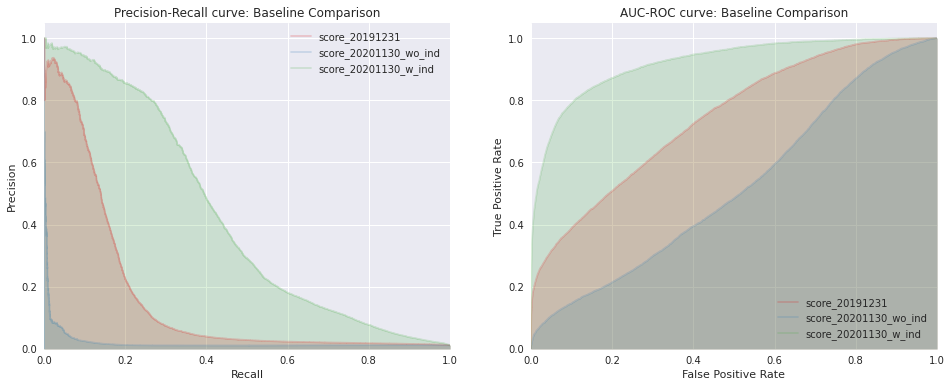

In [10]:
# make sure we scaled the correct score by looking at pr/auc with the old score - they should match

mntr_path = "./artifacts"
pred_cols = ['pred_20191231', 'pred_20201130_wo_ind', "pred_20201130_w_ind"]
mntr.save_valid_performance_plots(
        {"20201201": test_df}, "target", score_cols, mntr_path, dropna=False
    )

(570248, 106)

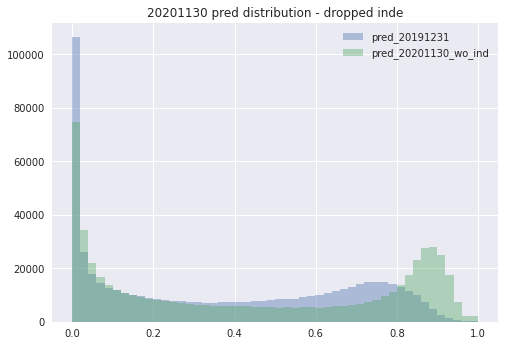

In [11]:
df_ = test_df#[~test_df.is_active 
             # & ~test_df.target]
display(df_.shape)

score_col = "pred_20191231"
df_[score_col].hist(bins=50, alpha=0.4, label=score_col)

score_col = "pred_20201130_wo_ind"
df_[score_col].hist(bins=50, alpha=0.4, label=score_col)


plt.title("20201130 pred distribution - dropped inde")
plt.legend()

(570248, 106)

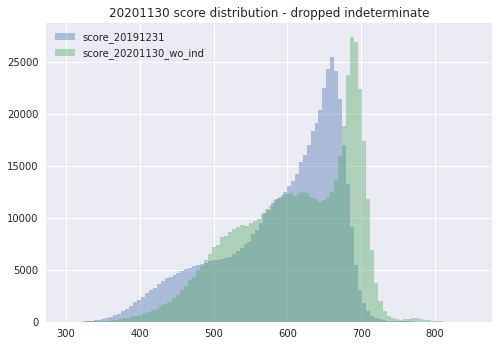

In [12]:
df_ = test_df#[~test_df.is_active 
             # & ~test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_20201130_wo_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)


plt.title("20201130 score distribution - dropped indeterminate")
plt.legend()

(471246, 106)

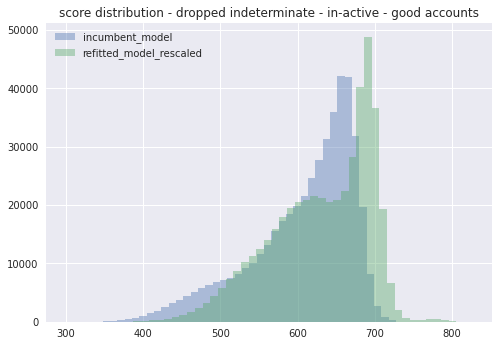

In [13]:
# score on the in active set
# activess defined as the group that had transaction in the past 30 days
df_ = test_df[~test_df.is_active 
              & ~test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=50, alpha=0.4, label="incumbent_model")

score_col = "score_20201130_wo_ind"
df_[score_col].hist(bins=50, alpha=0.4, label="refitted_model_rescaled")

plt.title("score distribution - dropped indeterminate - in-active - good accounts")
plt.legend()
plt.savefig("./artifacts/score_distr_inactive.png")

In [14]:
def plot_score_distr(df, ax, title):
    score_col = "score_20191231"
    df[score_col].hist(bins=50, alpha=0.4, label="incumbent_model", ax=ax)

    score_col = "score_20201130_wo_ind"
    df[score_col].hist(bins=50, alpha=0.4, label="refitted_model", ax=ax)
    
    ax.set_title(title)
    ax.legend()

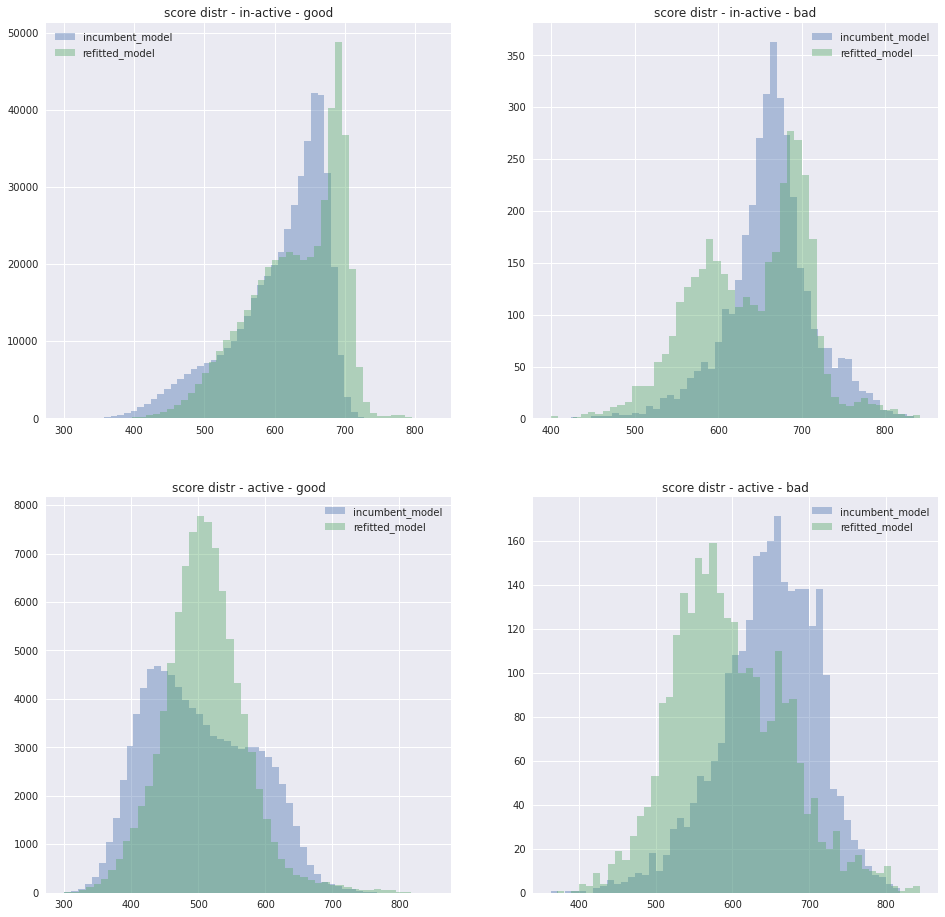

In [15]:
# plot 4x4
fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, axs[0, 0], "score distr - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, axs[0, 1], "score distr - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, axs[1, 0], "score distr - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, axs[1, 1], "score distr - active - bad")

plt.savefig("./artifacts/score_distr_wo_ind_n_target.png")

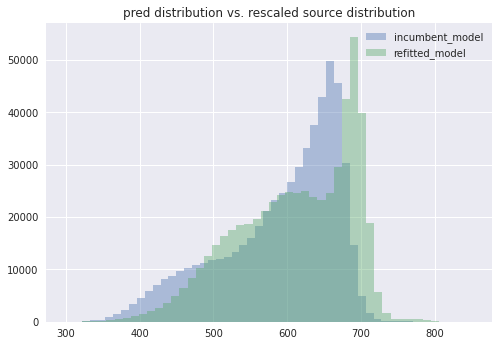

In [16]:
test_df["score_20191231"].hist(bins=50, alpha=0.4, label="incumbent_model")
test_df["score_20201130_wo_ind"].hist(bins=50, alpha=0.4, label="refitted_model")
plt.title("pred distribution vs. rescaled source distribution")
plt.legend()
plt.savefig("./artifacts/pred_distr.png")

Text(0.5, 1.0, 'Risk Group Shift - wo indeterminant')

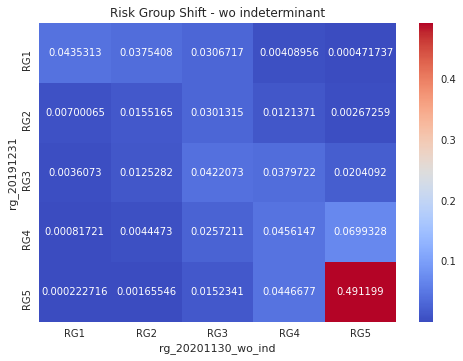

In [17]:
# look at risk groups
table = test_df[['rg_20191231', 'rg_20201130_wo_ind']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_20201130_wo_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_20201130_wo_ind', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - wo indeterminant')

In [18]:
print("ratio of users kept their RG: ", np.trace(table))

ratio of users kept their RG:  0.6380689998649676


In [19]:
np.triu(table, 1)

array([[0.        , 0.03754079, 0.03067167, 0.00408956, 0.00047174],
       [0.        , 0.        , 0.03013154, 0.01213714, 0.00267259],
       [0.        , 0.        , 0.        , 0.0379722 , 0.0204092 ],
       [0.        , 0.        , 0.        , 0.        , 0.06993282],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [20]:
print("ratio that went up in RG: ", np.triu(table,1).sum())
print("ratio that went down in RG: ", np.triu(table.T,1).sum())

ratio that went up in RG:  0.24602925470816314
ratio that went down in RG:  0.11590174542686937


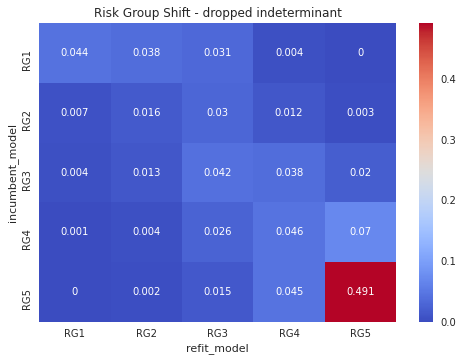

In [21]:
# look at risk groups
table = test_df[['rg_20191231', 'rg_20201130_wo_ind']].value_counts(normalize=True).sort_index().reset_index().round(3)
table.columns = ['incumbent_model', 'refit_model', 'counts']
table = pd.pivot_table(table, values='counts', index='incumbent_model', 
                       columns='refit_model', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - dropped indeterminant')
plt.savefig("./artifacts/rg_shift.png")

### Visualize RG shifts
---

#### Trained excluding indeterminant - same scaling

Text(0.5, 1.0, 'Risk Group Shift - excluded indeterminant')

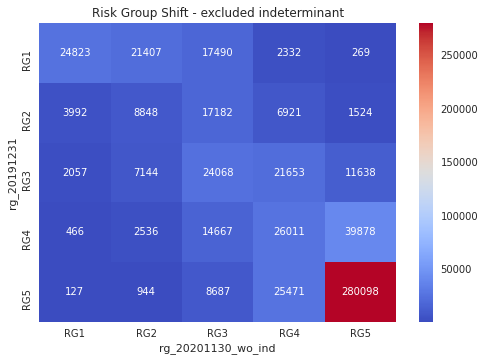

In [22]:
# compare the flow of risk groups 
table = test_df[['rg_20191231', 'rg_20201130_wo_ind']].value_counts().sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_20201130_wo_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_20201130_wo_ind', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - excluded indeterminant')

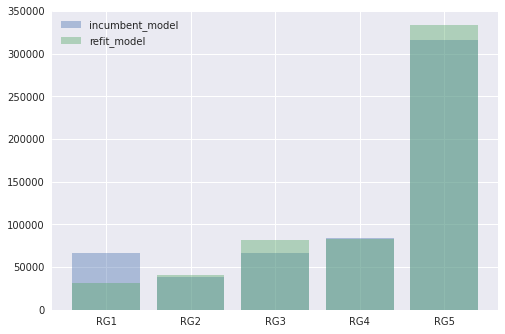

In [23]:
freq = test_df.rg_20191231.value_counts().sort_index()
plt.bar(freq.index, freq.values, label="incumbent_model", alpha=0.4)

freq = test_df.rg_20201130_wo_ind.value_counts().sort_index()
plt.bar(freq.index, freq.values, label="refit_model", alpha=0.4)

plt.legend()
plt.savefig("./artifacts/rg_distr.png")

### Swap Set
---
Explaination by Experian: [here](http://www.experian.com/blogs/insights/2018/01/swap-set-measure-impact-model-changes/)

We compute bad rates within different segments, along with the total bad rate across each RG for both models.

In [24]:
import rdsutils.swap_set_analysis as ssa

In [25]:
rg1 = "rg_20191231"
rg2 = "rg_20201130_wo_ind"
rg_tbl = ssa.get_swapset_table(test_df, rg1, rg2)
tgt_tbl = ssa.get_target_counts_table(test_df, rg1, rg2, "target")

In [26]:
tgt_tbl

rg_20201130_wo_ind,RG1,RG2,RG3,RG4,RG5,All
rg_20191231,,,,,,
RG1,15,7,13,5,1,41
RG2,14,19,21,6,3,63
RG3,45,68,103,59,14,289
RG4,21,77,207,133,99,537
RG5,26,97,684,1062,3499,5368
All,121,268,1028,1265,3616,6298


In [27]:
swapset = ssa.get_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=True)
swapset.style.background_gradient(cmap='coolwarm')

rg_20201130_wo_ind,RG1,RG2,RG3,RG4,RG5,All
rg_20191231,,,,,,
RG1,0.000604,0.000327,0.000743,0.002144,0.003717,0.000618
RG2,0.003507,0.002147,0.001222,0.000867,0.001969,0.001638
RG3,0.021877,0.009518,0.004280,0.002725,0.001203,0.004342
RG4,0.045064,0.030363,0.014113,0.005113,0.002483,0.006427
RG5,0.204724,0.102754,0.078738,0.041694,0.012492,0.017024
All,0.003846,0.006556,0.012522,0.015354,0.010846,0.011045


(<Figure size 864x360 with 4 Axes>,
 <AxesSubplot:title={'center':'rg shift: wo margins'}, xlabel='new model', ylabel='incumbent model'>)

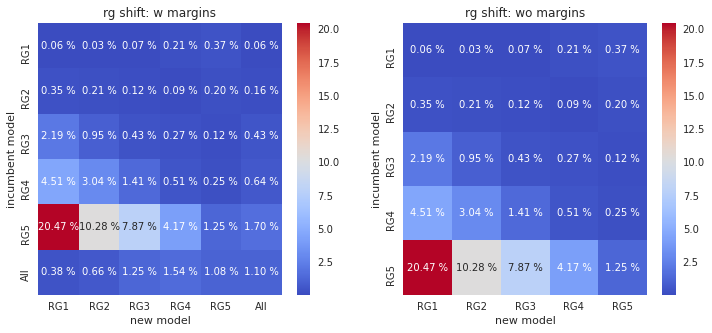

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=True, fig=fig, ax=axs[0],
                       title="rg shift: w margins",
                       xlabel="new model", ylabel="incumbent model")
ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=False, fig=fig, ax=axs[1],
                       title="rg shift: wo margins",
                       xlabel="new model", ylabel="incumbent model")

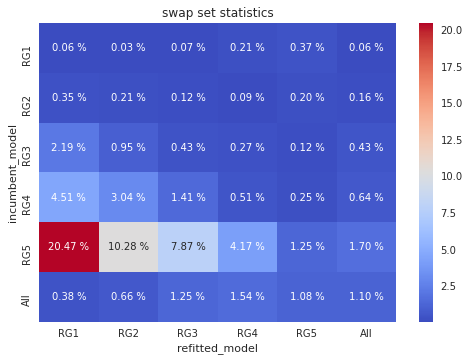

In [43]:
fig, ax = ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=True,
                                     title="swap set statistics",
                                     xlabel="refitted_model",
                                     ylabel="incumbent_model")
fig.savefig("./artifacts/swapset-stats.png")

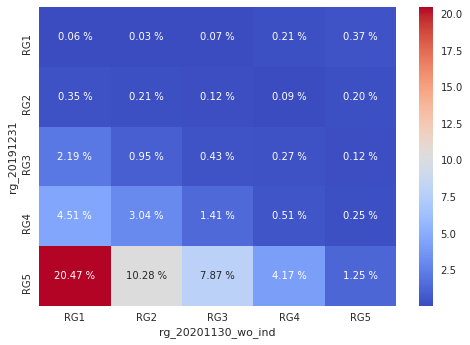

In [44]:
fig, ax = ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=False)

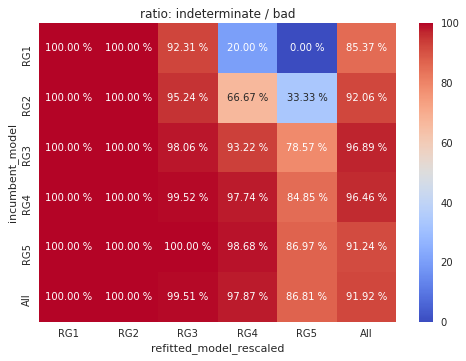

In [46]:
# among the bads, how many are indeterminates
fig, ax = plot_swap_set_bad_rate(test_df[test_df["target"]], rg1, rg2, "indeterminate", margins=True,
                                 title="ratio: indeterminate / bad",
                                 xlabel="refitted_model_rescaled",
                                 ylabel="incumbent_model")

In [6]:
test_df.columns

NameError: name 'test_df' is not defined

Text(0.5, 1.0, 'total users')

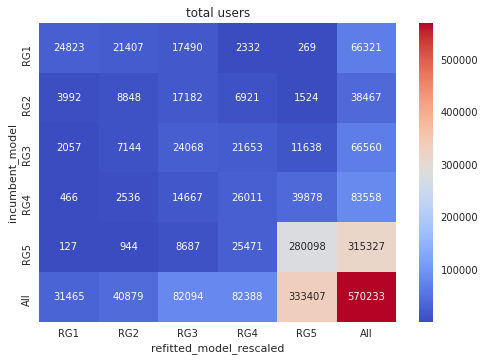

In [31]:
fig = plt.figure()
sns.heatmap(rg_tbl, cmap='coolwarm', annot=True, fmt='.6g')
plt.xlabel("refitted_model_rescaled")
plt.ylabel("incumbent_model")
plt.title('total users')

Text(0.5, 1.0, 'bad counts')

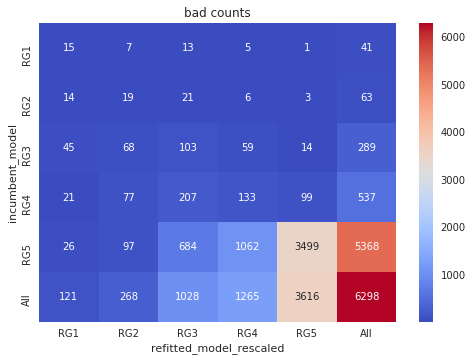

In [32]:
# plot those?
fig = plt.figure()
sns.heatmap(tgt_tbl, cmap='coolwarm', annot=True, fmt='.6g')
plt.xlabel("refitted_model_rescaled")
plt.ylabel("incumbent_model")
plt.title('bad counts')

### How many of the misclassified bads are indeterminates?
---

In [33]:
rg1_bads = test_df[(test_df["rg_20201130_wo_ind"] == "RG1")
                   & (test_df["rg_20191231"] == "RG5")
                   & test_df["target"]]
rg1_bads["indeterminate"].value_counts()

True    26
Name: indeterminate, dtype: int64

In [36]:
rg_hbr = test_df[test_df["target"]
                 & ((test_df["rg_20201130_wo_ind"].isin(["RG1", "RG2", "RG3"]))
                    & (test_df["rg_20191231"] == "RG5"))]
rg_hbr["indeterminate"].value_counts()

True    807
Name: indeterminate, dtype: int64

### Look at individual data in the uncatched bads in RG 1
---

* Are they indeterminates? 
* What is the nature of those?
* Are they ignoreable?
* Can we enforce it during training without doing a major overhaul?

In [42]:
rg1_bads = test_df[(test_df["rg_20201130_wo_ind"] == "RG1")
                   & (test_df["rg_20191231"] == "RG5")
                   & test_df["target"]]

In [43]:
rg1_bads.shape

(26, 106)

In [46]:
rg1_bads.head(10)

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,pred_20201130_wo_ind,score_20201130_wo_ind,pred_20201130_w_ind,score_20201130_w_ind,rg_20191231,rg_20201130_wo_ind,rg_20201130_w_ind,score_rescaled_20201130_w_ind,rg_rescaled_20201130_w_ind,is_active
251426,2020-12-01 00:00:00,11054321.0,410009478050,ACHDWP2P,-27.00,********0577,1002.00,17227861,False,None,...,0.004883,468.111052,0.838164,682.620819,RG5,RG1,RG5,840.706044,RG5,True
1871323,2020-12-01 00:00:00,11193290.0,410010128577,ACHDWP2P,-478.00,********8104,27.00,17370847,False,2021-02-04,...,0.005815,473.524285,0.985873,762.758543,RG5,RG1,RG5,850.000000,RG5,True
1903556,2020-12-01 00:00:00,11142764.0,410009970596,ACHDWP2P,-240.00,********4506,1.00,17328889,False,None,...,0.003955,461.590856,0.977226,747.772421,RG5,RG1,RG5,850.000000,RG5,True
5104277,2020-11-15 07:32:44,6987250.0,410008951552,POSDW,-15.00,,0.03,13166689,False,None,...,0.000679,407.190326,0.901846,700.284890,RG5,RG1,RG5,850.000000,RG5,True
5110077,2020-11-18 07:53:14,7113779.0,410005326470,DWACHRET,-4999.71,,-594862.24,13296799,False,2020-12-29,...,0.001118,422.565434,0.995012,795.118741,RG5,RG1,RG5,850.000000,RG5,True
5114793,2020-11-30 00:03:32,7197831.0,410001085669,IIPD,0.00,,-499.23,13380741,False,2021-01-06,...,0.005322,470.779694,0.995237,796.549651,RG5,RG1,RG5,850.000000,RG5,True
5115487,2020-10-04 08:11:07,7207946.0,410001116963,POSDD,12.99,,203.63,13394303,False,None,...,0.004303,464.200520,0.554570,638.698151,RG5,RG1,RG5,756.172047,RG5,False
5259749,2020-11-20 18:22:35,9632266.0,410004703020,DD,282.50,,-1199.41,15809747,False,2020-12-18,...,0.002108,442.147579,0.995521,798.449667,RG5,RG1,RG5,850.000000,RG5,True
5262367,2020-11-30 00:04:36,9661419.0,410004842346,IIPD,0.00,,23.84,15839264,False,None,...,0.005040,469.092436,0.709501,659.459975,RG5,RG1,RG5,796.130456,RG5,True
5279674,2020-11-09 04:16:11,9846835.0,410005168003,ACHDDIN,32.51,,-50935.30,16024774,False,2020-12-23,...,0.002748,450.329581,0.974340,744.004849,RG5,RG1,RG5,850.000000,RG5,True


In [47]:
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_w_ind.pkl", "rb") as f:
    clf_w_ind = pkl.load(f)
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_wo_ind.pkl", "rb") as f:
    clf_wo_ind = pkl.load(f)
with open("../../artifacts/refitting-202021Q1/customer_risk_target_no_giact_time_since_last_link.pkl", "rb") as f:
    prev_model = pkl.load(f)

In [56]:
cols = prev_model.feature_name_
df_ = rg1_bads[cols+["score_20191231", "score_20201130_wo_ind"]].sort_values("score_20201130_wo_ind")
df_.head()

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,score_20191231,score_20201130_wo_ind
5104277,1000.00,832.0,3.0,0.848,0.825,0.5046,-0.399521,450.103333,0.925,0.0850,...,0.0,0.0,643.0,0.0729,39,1,-1.0,-1.0,628.014305,407.190326
5598913,240.00,757.0,40.0,0.999,0.962,0.5000,-0.995833,120.500000,0.973,0.1843,...,0.0,0.0,22321.0,0.9589,7,0,-1.0,-1.0,667.680170,420.666871
5336861,149900.00,778.0,21.0,0.999,0.996,0.0100,-0.016640,68077.473611,0.909,0.0433,...,0.0,0.0,4101.0,0.8935,126,8,-1.0,-1.0,607.623655,422.539936
5110077,2000.00,562.0,NaN,0.286,0.570,0.9959,0.008476,-594862.240000,0.374,0.0438,...,0.0,1.0,0.0,0.0747,644,0,996.0,996.0,692.107350,422.565434
5494301,499.75,831.0,4.0,0.919,0.975,0.0100,0.000000,0.000000,0.794,0.9096,...,0.0,0.0,2053.0,0.8816,56,0,-1.0,-1.0,615.471578,439.542368


In [199]:
import shap

shap.initjs()

In [200]:
explainer = shap.TreeExplainer(prev_model)
shap_values = explainer(df_[prev_model.feature_name_])

In [201]:
new_explainer = shap.TreeExplainer(clf_wo_ind)
new_shap_values = explainer(df_[clf_wo_ind.feature_name_])

In [202]:
idx = 0
shap.force_plot(explainer.expected_value[1], shap_values[idx, :].values[:, 1], 
                df_[prev_model.feature_name_].iloc[idx, :])

In [203]:
idx = 0
shap.force_plot(new_explainer.expected_value.item(), new_shap_values[idx, :].values[:, 1], 
                df_[clf_wo_ind.feature_name_].iloc[idx, :])

In [204]:
df_[["score_20191231", "score_20201130_wo_ind"]].iloc[idx]

score_20191231           628.014305
score_20201130_wo_ind    407.190326
Name: 5104277, dtype: float64

In [205]:
idx = 3
shap.force_plot(explainer.expected_value[1], shap_values[idx, :].values[:, 1], 
                df_[prev_model.feature_name_].iloc[idx, :])

In [206]:
shap.force_plot(new_explainer.expected_value.item(), new_shap_values[idx, :].values[:, 1], 
                df_[clf_wo_ind.feature_name_].iloc[idx, :])

In [207]:
df_[["score_20191231", "score_20201130_wo_ind"]].iloc[idx]

score_20191231           692.107350
score_20201130_wo_ind    422.565434
Name: 5110077, dtype: float64

On the scale of shap values with the misclassfied data, the SV does not differ much between the new and the old model. Maybe it is due to boundary cases made worse the scaling? - Will take longer if drill deep.

In [208]:
# maybe look at typical shap value difference?

### Produce Segmented Performances

## Money Model Pipeline Issues
---
* Issue: Current Money Model Development Pipelines is/will soon no longer work.
    * Issue 1 Urgent: Not able to refit Money Deposit models, as a reduced feature pipeline is still too big for the largest AWS SageMaker instance to carry. 
    * Issue 2 Urgent: The Money Customer model shares part of the Money Deposit model pipeline, and is expected to end up in a similar situation in months.
    * Issue 3 Long-term: SoFi Data Platform would require all teams to migrate away from Data Lake and Postgres Data Warehouse to Snowflake DW. They are expecting to retire all of them in the next 12 months.

* Timeline
    * Issue 1 is already happening. 
    * Issue 2 should be soon. My best estimate for that to happen is in 1-2 months.
    * Issue 3 is not on the near-term horizon but is something that fits together with the current status.

* What has caused the issue
    * Geometric growth in the amount of data we have. Our YoY growth rate for 2020 was 150% 
    * Complex transactions feature engineering logic that is currently in-place
    * Both computationally and memory expensive

* Impact
    * All money model pipelines won't be able to function, which means we won't be able to produce development data for monitoring, refitting, or any other activities that concerns with dev data.
    * (Regarding the first question you asked me today: The current customer risk model refitting exercise can still function.)

* What we need
    * We need either data engineering support or allocated resource/priority to migrate to a computing method that is fault-tolerant, meaning it will produce accurate results in a reasonable amount of time.

* What we had done to address it
    * I have increased the SageMaker instance size to m5.24xlarge, largest regular computational instance that is available to us.
    * To combat the most recent occurrence, I had reduced the number of features we used to compute from >150 to 71 that is required for all current models, which still explodes the machine.
    * It has been 4 months since the first time I talked about this issue in the team meeting at the end of 2020, I tried multiple methods (Dask, Parallel computing with Multi-processing, and vertical scaling) that carried us until now. However, it is out-growing the largest SageMaker instance that is available to us. This is a conversation shared by Member's, Ops, and Risk DS modelers, as vertical scaling can only carry us so far.
    
* Options

    * Quick fixes: I can see two quick fixes that may function as a band-aid for a short period of time
        1. brake data by chunks, and compute each chunk sequentially. 
            * Pros: I expect it will take about two weeks to implement, debug, and validate.
            * Cons: 
                * this is still kicking the can down the road as it would negatively impact the time it takes to iterate on models
                * This will further complicate the pipeline that is already not easy to comprehend -> creating a bigger pile of technical debt
        2. Build models with sampled data. Instead of using all SoFi users, we only use a fraction of them for training. Need to communicate with MRM and Business
    * Produce a customer model with reduced features
    * Proposed solution
        * Move to a distributed computing method that is supported by SoFi Data Platform. Maybe it would be a good option to move to a distributed computing platform that is fault-tolerant and will be able to produce results in a reasonable amount of time. 
        * Pro: We will not see the computation issue in the near future, as we will be able to utilize horizontal scaling as more data is collected
        * Con: This in itself is a mid-term project worth making onto our team timeline. I expect it to take at least a month to complete the feature engineering process.


In [ ]:
# fault tolerance

In [69]:
score_cols = ['pred_20191231', 'pred_20201130_wo_ind']

In [70]:
report = mntr.get_pred_reports(test_df, "target", score_cols, dropna=True)
report

,auc,ap,ks
pred_20191231,74.70,16.18,32.52
pred_20201130_wo_ind,52.23,1.99,7.37


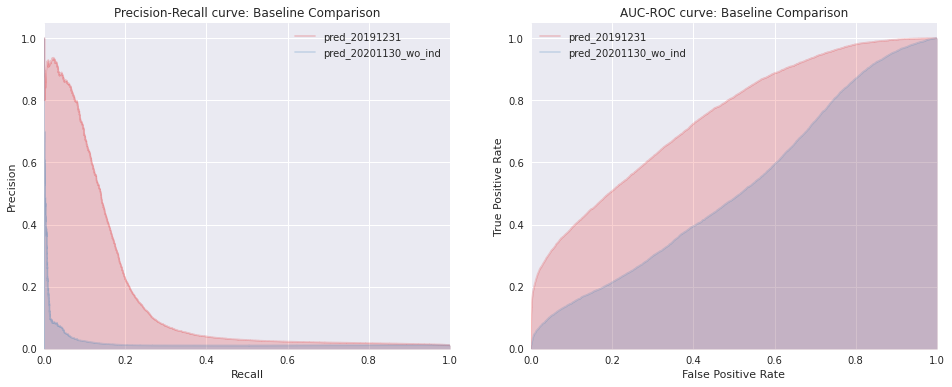

In [61]:
mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"20201201": test_df}, "target", score_cols, mntr_path, dropna=False
    )

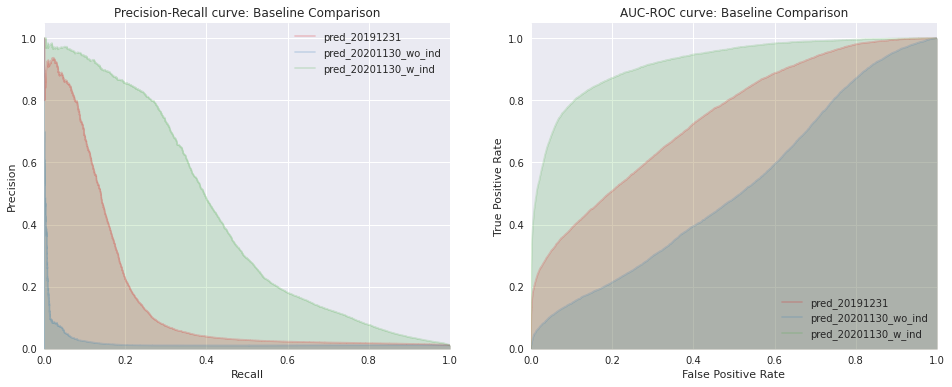

In [60]:
mntr_path = "./artifacts"
score_cols = ['pred_20191231', 'pred_20201130_wo_ind', "pred_20201130_w_ind"]
mntr.save_valid_performance_plots(
        {"20201201": test_df}, "target", score_cols, mntr_path, dropna=False
    )

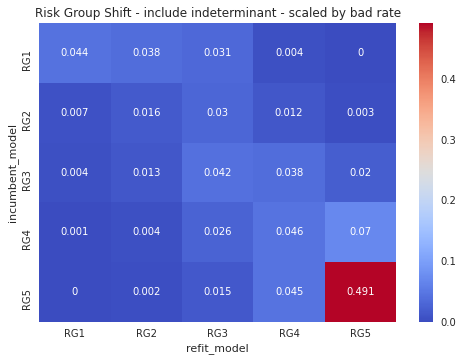

In [56]:
# look at risk groups
table = test_df[['rg_20191231', 'rg_20201130_wo_ind']].value_counts(normalize=True).sort_index().reset_index().round(3)
table.columns = ['incumbent_model', 'refit_model', 'counts']
table = pd.pivot_table(table, values='counts', index='incumbent_model', 
                       columns='refit_model', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - include indeterminant - scaled by bad rate')
plt.savefig("./artifacts/rg_shift.png")

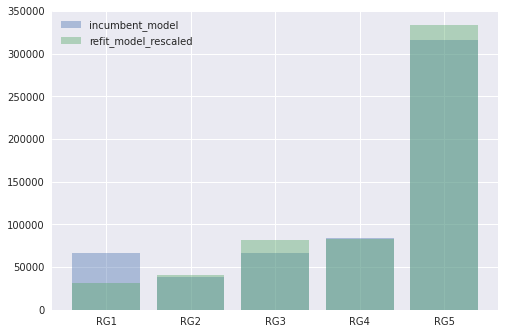

In [57]:
freq = test_df.rg_20191231.value_counts().sort_index()
plt.bar(freq.index, freq.values, label="incumbent_model", alpha=0.4)

freq = test_df.rg_20201130_wo_ind.value_counts().sort_index()
plt.bar(freq.index, freq.values, label="refit_model_rescaled", alpha=0.4)

plt.legend()
plt.savefig("./artifacts/rg_distr.png")

Text(0.5, 1.0, 'total users')

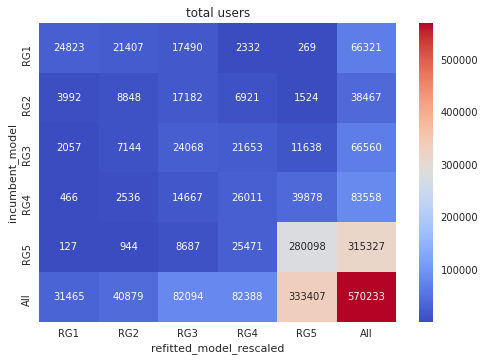

In [66]:
fig = plt.figure()
sns.heatmap(rg_tbl, cmap='coolwarm', annot=True, fmt='.6g')
plt.xlabel("refitted_model_rescaled")
plt.ylabel("incumbent_model")
plt.title('total users')

Text(0.5, 1.0, 'bad counts')

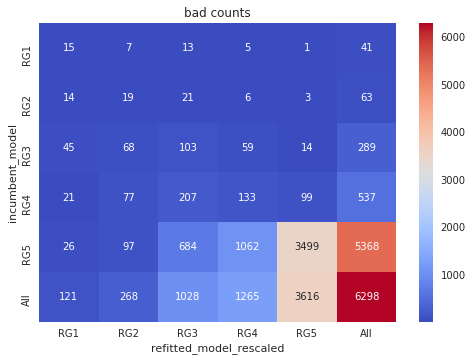

In [67]:
# plot those?
fig = plt.figure()
sns.heatmap(tgt_tbl, cmap='coolwarm', annot=True, fmt='.6g')
plt.xlabel("refitted_model_rescaled")
plt.ylabel("incumbent_model")
plt.title('bad counts')

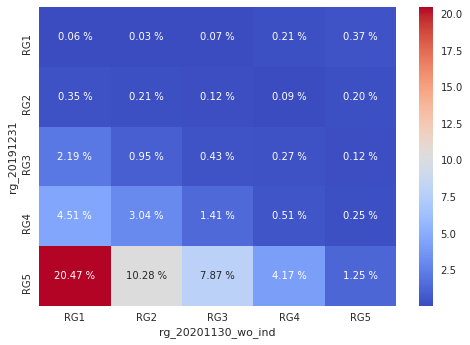

In [68]:
fig, ax = ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=False)